In [1]:
# 导入合适的库
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# 导入数据
params = np.loadtxt('0823paramsnp.txt')  # [T1, mb, kesi, PGA, PGV, PGD, Sd, Sv, Sa]
edpResults = np.loadtxt('0823edpResult.txt')

In [3]:
# 数据抓换成torch格式
train_x = torch.from_numpy(params[:1600, :4]).to(torch.float) 
train_y = torch.from_numpy(edpResults[:1600, 0]).to(torch.float)

In [15]:
train_x.size()

torch.Size([1600, 4])

In [4]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [5]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 0.736
Iter 2/50 - Loss: 0.707
Iter 3/50 - Loss: 0.663
Iter 4/50 - Loss: 0.626
Iter 5/50 - Loss: 0.590
Iter 6/50 - Loss: 0.548
Iter 7/50 - Loss: 0.505
Iter 8/50 - Loss: 0.465
Iter 9/50 - Loss: 0.425
Iter 10/50 - Loss: 0.382
Iter 11/50 - Loss: 0.337
Iter 12/50 - Loss: 0.293
Iter 13/50 - Loss: 0.250
Iter 14/50 - Loss: 0.205
Iter 15/50 - Loss: 0.158
Iter 16/50 - Loss: 0.111
Iter 17/50 - Loss: 0.065
Iter 18/50 - Loss: 0.018
Iter 19/50 - Loss: -0.031
Iter 20/50 - Loss: -0.079
Iter 21/50 - Loss: -0.127
Iter 22/50 - Loss: -0.178
Iter 23/50 - Loss: -0.226
Iter 24/50 - Loss: -0.276
Iter 25/50 - Loss: -0.327
Iter 26/50 - Loss: -0.376
Iter 27/50 - Loss: -0.428
Iter 28/50 - Loss: -0.479
Iter 29/50 - Loss: -0.530
Iter 30/50 - Loss: -0.581
Iter 31/50 - Loss: -0.633
Iter 32/50 - Loss: -0.684
Iter 33/50 - Loss: -0.737
Iter 34/50 - Loss: -0.787
Iter 35/50 - Loss: -0.840
Iter 36/50 - Loss: -0.892
Iter 37/50 - Loss: -0.943
Iter 38/50 - Loss: -0.995
Iter 39/50 - Loss: -1.049
Iter 40/50 - 

In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.from_numpy(params[1600:, :4]).to(torch.float)
    observed_pred_test = likelihood(model(test_x))

In [8]:
from sklearn.metrics import r2_score
r_squared_sklearn_test = r2_score(edpResults[1600:, 0], observed_pred_test.mean.numpy())
print(r_squared_sklearn_test)

-2.514847064580359


In [9]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # test_x = torch.from_numpy(params[1600:]).to(torch.float)
    observed_pred_train = likelihood(model(train_x))

c:\ProgramData\miniconda3\envs\torchenv310\lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [10]:
from sklearn.metrics import r2_score
r_squared_sklearn_train = r2_score(edpResults[:1600, 0], observed_pred_train.mean.numpy())
print(r_squared_sklearn_train)

-2.8365220489142384


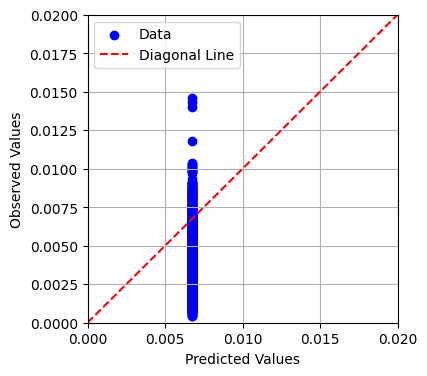

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据（模拟预测值和观测值）
np.random.seed(0)
# observed_values = edpResults[:1600, 0]
# predicted_values = observed_pred_train.mean.numpy()
observed_values = edpResults[:1600, 0]
predicted_values = observed_pred_train.mean.numpy()
# 绘制散点图和对角线
a = 0.02
plt.figure(figsize=(4,4))
plt.scatter(predicted_values, observed_values, color='blue', label='Data')
plt.plot([0, a], [0, a], color='red', linestyle='--', label='Diagonal Line')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.xlim([0, 0.02])
plt.ylim([0, 0.02])
# plt.title('QQ Plot with Diagonal Line')
plt.legend()
plt.grid(True)
plt.show()